分析训练集中这四个指标的平稳性，对于不平稳的，要对其进行差分运算，使差分后的序列变得平稳，然后才能建立VAR模型

In [1]:
import pandas as pd
import numpy as np
src_canada = pd.read_csv("http://image.cador.cn/data/canada.csv")
val_columns = ['e','prod','rw','U']
v_std = src_canada[val_columns].apply(lambda x:np.std(x)).values
v_mean = src_canada[val_columns].apply(lambda x:np.mean(x)).values
canada = src_canada[val_columns].apply(lambda x:(x-np.mean(x))/np.std(x))
train = canada.iloc[0:-8]

import statsmodels.tsa.stattools as stat
for col in val_columns:
    pvalue = stat.adfuller(train[col],1)[1]
    print("指标",col,"单位根检验的p值为： ",pvalue)

指标 e 单位根检验的p值为：  0.8663327869244546
指标 prod 单位根检验的p值为：  0.8586871782128878
指标 rw 单位根检验的p值为：  0.0013531962631896082
指标 U 单位根检验的p值为：  0.11133330647767575


进一步进行差分运算（为便于处理，这里对四个指标同时进行差分）

In [2]:
# 由于这四个指标都不平稳，因此需要进行合适的差分运算
train_diff = train.apply(lambda x: np.diff(x),axis=0)

for col in val_columns:
    pvalue = stat.adfuller(train_diff[col],1)[1]
    print("指标",col,"单位根检验的p值为： ",pvalue)

指标 e 单位根检验的p值为：  0.0004156438933942739
指标 prod 单位根检验的p值为：  1.2492333501288617e-08
指标 rw 单位根检验的p值为：  4.5335282339883554e-06
指标 U 单位根检验的p值为：  0.00023868665380719157


我们使用最小二乘法，求解每个方程的系数，并通过逐渐增加阶数，为模型定阶

In [3]:
# 模型阶数从1开始逐一增加
rows, cols = train_diff.shape
aicList = []
lmList = []

for p in range(1,11):
    baseData = None
    for i in range(p,rows):
        tmp_list = list(train_diff.iloc[i]) + list(train_diff.iloc[i-p:i].values.flatten())
        if baseData is None:
            baseData = [tmp_list]
        else:
            baseData = np.r_[baseData, [tmp_list]]
    X = np.c_[[1]*baseData.shape[0],baseData[:,cols:]]
    Y = baseData[:,0:cols]
    coefMatrix = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),Y)
    aic = np.log(np.linalg.det(np.cov(Y - np.matmul(X,coefMatrix),rowvar=False))) + 2*(coefMatrix.shape[0]-1)**2*p/baseData.shape[0]
    aicList.append(aic)
    lmList.append(coefMatrix)

#对比查看阶数和AIC
pd.DataFrame({"P":range(1,11),"AIC":aicList})

,P,AIC
0,1,-19.996796
1,2,-17.615455
2,3,-9.407306
3,4,6.907540
4,5,34.852248
5,6,77.620404
6,7,138.382810
7,8,220.671801
8,9,328.834718
9,10,466.815468


基于该模型，对未来8期的数据进行预测，并与验证数据集进行比较分析

In [4]:
p = np.argmin(aicList)+1
n = rows
preddf = None
for i in range(8):
    predData = list(train_diff.iloc[n+i-p:n+i].values.flatten())
    predVals = np.matmul([1]+predData,lmList[p-1])
    # 使用逆差分运算，还原预测值
    predVals=train.iloc[n+i,:]+predVals
    if preddf is None:
        preddf = [predVals]
    else:
        preddf = np.r_[preddf, [predVals]]
        
    # 为train增加一条新记录
    train = train.append(canada[n+i+1:n+i+2],ignore_index=True)
    # 为train_diff增加一条新记录
    df = pd.DataFrame(list(canada[n+i+1:n+i+2].values - canada[n+i:n+i+1].values), columns=canada.columns)
    train_diff = train_diff.append(df,ignore_index=True)
    
preddf = preddf*v_std + v_mean

#分析预测残差情况
preddf - src_canada[canada.columns].iloc[-8:].values

array([[ 0.20065717, -0.7208273 ,  0.08095578, -0.18725653],
       [ 0.03650856, -0.08061888,  0.05900709, -0.22667618],
       [ 0.03751544, -0.87174186,  0.17291551,  0.10381011],
       [-0.04826459, -0.06498827,  0.45879439,  0.34885492],
       [-0.15647981, -0.6096229 , -1.1219943 , -0.12520269],
       [ 0.51480518, -0.51864268,  0.7123945 , -0.2760806 ],
       [ 0.32312138, -0.06077591, -0.14816924, -0.39923473],
       [-0.34031027,  0.78080541,  1.31294708,  0.01779691]])

In [5]:
#统计预测百分误差率分布
pd.Series((np.abs(preddf - src_canada[canada.columns].iloc[-8:].values)*100/src_canada[canada.columns].iloc[-8:].values).flatten()).describe()

count    32.000000
mean      0.799252
std       1.551933
min       0.003811
25%       0.018936
50%       0.111144
75%       0.264179
max       5.760963
dtype: float64

绘制二维图表观察预测数据与真实数据的逼近情况

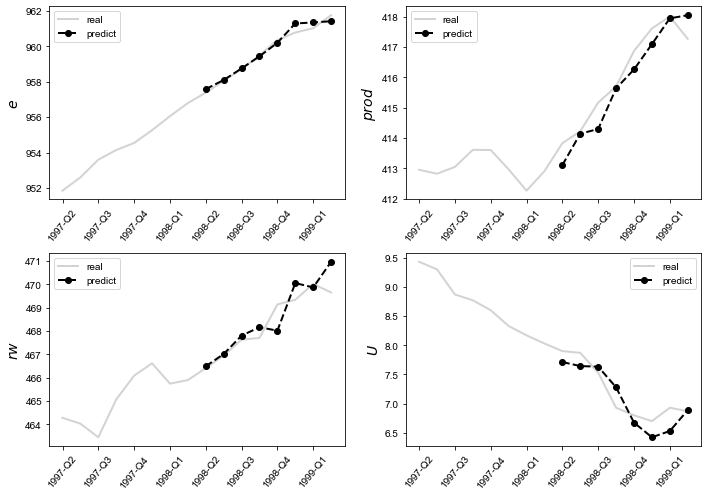

In [6]:
import matplotlib.pyplot as plt
import matplotlib
# 以下 font.family 设置仅适用于 Mac系统，其它系统请使用对应字体名称
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'
m = 16
xts = src_canada[['year','season']].iloc[-m:].apply(lambda x:str(x[0])+'-'+x[1],axis=1).values
fig, axes = plt.subplots(2,2,figsize=(10,7))
index = 0
for ax in axes.flatten():
    ax.plot(range(m),src_canada[canada.columns].iloc[-m:,index],'-',c='lightgray',linewidth=2,label="real")
    ax.plot(range(m-8,m),preddf[:,index],'o--',c='black',linewidth=2,label="predict")
    ax.set_xticklabels(xts,rotation=50)
    ax.set_ylabel("$"+canada.columns[index]+"$",fontsize=14)
    ax.legend()
    index = index + 1
plt.tight_layout()
plt.show()